In [1]:
# Packages

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import datetime
import numpy as np


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
# Load Fitbit data
series_raw = read_csv('./Mike_Fitbit_data.csv')
series = series_raw[['Date', 'Steps', 'Minutes.Asleep', 'Minutes.Very.Active', 'Floors', 'Distance']]
series['Date'] = [datetime.strptime(date,'%Y-%m-%d') for date in series['Date']] 
series.index = series['Date']
series = series[['Minutes.Asleep', 'Steps',  'Minutes.Very.Active', 'Floors', 'Distance']]
series.head()
series.describe()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Minutes.Asleep,Steps,Minutes.Very.Active,Floors,Distance
count,211.000000,211.000000,211.000000,211.000000,211.00000
mean,437.146919,12302.914692,37.559242,27.208531,6.03436
std,72.369108,3817.754663,30.495278,12.243331,2.00590
min,83.000000,600.000000,0.000000,0.000000,0.28000
25%,405.500000,9380.500000,10.000000,20.000000,4.40000
50%,439.000000,12336.000000,38.000000,26.000000,6.15000
75%,477.000000,14781.000000,59.000000,32.500000,7.51500
max,599.000000,27048.000000,153.000000,82.000000,12.69000


In [17]:
# Mark all NA with median value
def fillNA(data, var):
    filler = np.median(data[var])
    data[var].fillna(filler, inplace=True)
    return data

for i in series.columns:
    series[i] = fillNA(series, i)
    
series.describe()


,Minutes.Asleep,Steps,Minutes.Very.Active,Floors,Distance
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,437.146919,437.146919,437.146919,437.146919,437.146919
std,72.369108,72.369108,72.369108,72.369108,72.369108
min,83.000000,83.000000,83.000000,83.000000,83.000000
25%,405.500000,405.500000,405.500000,405.500000,405.500000
50%,439.000000,439.000000,439.000000,439.000000,439.000000
75%,477.000000,477.000000,477.000000,477.000000,477.000000
max,599.000000,599.000000,599.000000,599.000000,599.000000


In [18]:
# Save csv to file for future
#series.to_csv('~/Fitbit_steps_sleep.csv')

# Load dataset
#dataset = read_csv('~/Fitbit_steps_sleep.csv', header=0, index_col=0)
dataset = series


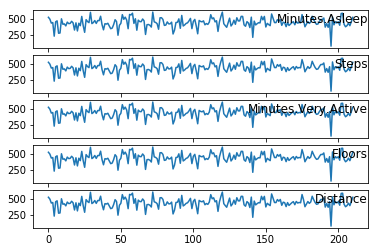

In [19]:
# Plot TS
values = dataset.values
groups = [0, 1, 2, 3, 4]
i = 1

pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


In [20]:
# convert series to supervised learning 
"""Direct from website: 
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
# Convert data to float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# Specify the number of lag hours
n_days = 7
n_features = 5


# Frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
reframed.head()


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
7,0.846899,0.846899,0.846899,0.846899,0.846899,0.792636,0.792636,0.792636,0.792636,0.792636,...,0.742248,0.742248,0.742248,0.742248,0.742248,0.377907,0.377907,0.377907,0.377907,0.377907
8,0.792636,0.792636,0.792636,0.792636,0.792636,0.676357,0.676357,0.676357,0.676357,0.676357,...,0.377907,0.377907,0.377907,0.377907,0.377907,0.385659,0.385659,0.385659,0.385659,0.385659
9,0.676357,0.676357,0.676357,0.676357,0.676357,0.691860,0.691860,0.691860,0.691860,0.691860,...,0.385659,0.385659,0.385659,0.385659,0.385659,0.802326,0.802326,0.802326,0.802326,0.802326
10,0.691860,0.691860,0.691860,0.691860,0.691860,0.292636,0.292636,0.292636,0.292636,0.292636,...,0.802326,0.802326,0.802326,0.802326,0.802326,0.641473,0.641473,0.641473,0.641473,0.641473
11,0.292636,0.292636,0.292636,0.292636,0.292636,0.715116,0.715116,0.715116,0.715116,0.715116,...,0.641473,0.641473,0.641473,0.641473,0.641473,0.653101,0.653101,0.653101,0.653101,0.653101


In [22]:
# Split dataset for training -- Learn from first 3/4, test on last 1/4
values = reframed.values
n_obs = n_days*n_features

n_train = int(0.75*len(values))
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

print(train_X.shape, len(train_X), train_y.shape)

(153, 35) 153 (153,)


In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(153, 7, 5) (153,) (51, 7, 5) (51,)


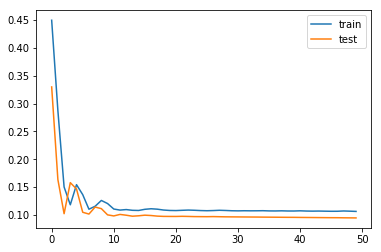

In [24]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# Plot history
pyplot.plot(history.history['loss'], label="train")
pyplot.plot(history.history['val_loss'], label="test")
pyplot.legend()
pyplot.show()


In [27]:
# Evaluate model

# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print("Test RMSE: %.3f" % rmse)


Test RMSE: 75.191


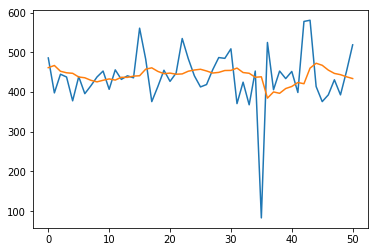

In [28]:
# Plot TS of predicted/actual
pyplot.plot(inv_y)
pyplot.plot(inv_yhat)
pyplot.legend()
pyplot.show()